# Peak Finding Tests

A notebook for prototyping new peak finding methods in Fe XVIII

First, a trial translation of the algorithm as implemented in IDL.

In [424]:
def detect_events_idl(data, noisethreshold=0, swidth=25, time_window=10,
                      backfill=True):
    """
    Count events in Fe XVIII lightcurve
    
    This is an exact translation of the IDL code.
    
    Parameters
    ----------
    data : 
        Single-pixel lightcurve as a function of time
    noisethreshold : 
    swidth :
    time_window :
    """
    #0: exist/not, 1: start, 2: peak, 3: end
    event=np.zeros(data.shape[:1]+(4,), dtype=int)
    trend=np.zeros(data.shape[:1]) * np.nan
    threshold=np.zeros(data.shape[:1]+(2,))

    # TODO: work out how to handle this with 3D array
    lc = convolve(data, Box1DKernel(swidth))
    
    # TODO: rename all to time_window
    # Time window and spatial interval to determine threshold
    dt=time_window
    
    trend[dt:] = np.sign(np.diff(lc)[dt-1:])
    
    for k in range(dt,event.shape[0]):
        # If last point was part of event
        if event[k-1,0]:
            # If increasing trend
            if trend[k] >= 0:
                # If still looking for peak, set this point as peak
                if event[k-1,2] == k-1:
                    event[event[k-1,1]:k+1,0] = True
                    event[event[k-1,1]:k+1,1] = event[k-1,1]
                    event[event[k-1,1]:k+1,2:] = k 
                    threshold[k,0]=max(threshold[k-1,0], noisethreshold)
                # If looking for a potential new peak, then see if above new threshold
                else:
                    threshold[k,0]=max(threshold[k-1,0], noisethreshold)	    
                    i_peak_last = event[k-1,2]
                    # NOTE: this is really only needed for the 3D case
                    i_min = np.argmin(lc[i_peak_last:k+1])
                    value = np.median(lc[i_peak_last+i_min])
                    svalue = np.std(lc[i_peak_last+i_min])
                    threshold[k,1] = max(value+svalue, noisethreshold)
                    # Mark as new event if above threshold
                    if lc[k] > threshold[k,1]:
                        # End earlier past event if equal to this start
                        if event[k-1,3] == k:
                            event[np.where(event[:,3]==k),3]=k-1
                        event[k,0]=1	    #Event
                        event[k,1:]=k	    #Start, peak, end
                        threshold[k,0]=threshold[k,1]
                    # Otherwise Still same event 
                    else:
                        event[k,0]=True  #Event
                        event[event[k-1,1]:k+1,1]=event[k-1,1]
                        event[event[k-1,1]:k+1,2]=event[k-1,2]  
                        event[event[k-1,1]:k+1,3]=k
            # If decreasing trend
            if trend[k] < 0:
                threshold[k,0]=max(threshold[k-1,0], noisethreshold)
                # If greater than threshold => still event
                if lc[k] > threshold[k,0]:    
                    peak=np.argmax(lc[event[k-1,1]:k+1])
                    event[k,0] = True
                    event[event[k-1,1]:k+1,1] = event[k-1,1]
                    event[event[k-1,1]:k+1,2] = peak + event[k-1,1]
                    event[event[k-1,1]:k+1,3] = k
                # If last point was not part of event
        # If previous point was NOT an event
        else:
            # Define threshold
            ptmin=np.argmin(lc[k-dt:k+1])
            value=np.median(sdata[k-dt+ptmin])
            svalue=np.std(sdata[k-dt+ptmin])
            threshold[k,0]=max(value+svalue, noisethreshold)
            # If larger than threshold, start event.
            if lc[k] > threshold[k,0]:
                event[k, 0] = True  #Event
                event[k, 1:] = k  #Start, peak, end
        
        # If new event (different start times), check if past event is larger than 3 datapoints.
        if event[k,1] != event[k-1,1]:
            if event[k-1,0]:
                pts=np.where(event[:,1] == event[k-1,1])[0]
                # If less than 3 datapoints
                if pts.shape[0] < 3:
                    # If event interrupted previous event, check if these points belong to that event
                    if event[pts[0]-1,0] == 1:
                        # If above threshold
                        if lc[pts[-1]] > threshold[pts[0]-1,0]:
                            start_old=int(event[pts[0]-1,1])	# Old start    
                            event[pts,1]=start_old	# Set old start for short event
                            newpts=np.where(event[:,1] == start_old)
                            event[newpts,0]=True
                            event[newpts,1]=start_old
                            event[newpts,2]=np.argmax(lc[start_old:pts[-1]+1]) + start_old	  
                            event[newpts,3]=pts[-1]	
                        else:
                        # otherwise set to zero
                            event[pts,:]=0
                    # otherwise set to zero
                    else:
                        event[pts,:]=0

    # Go over all events found.
    # Extend start times and end times to start and end of 
    # increasing and decreasing trends.
    event = event.astype(int)
    start=event[:,1]
    peaks=event[:,2]
    endt=event[:,3]
    good=np.where(endt != 0)
    ngood = good[0].shape[0]
    start=start[good]
    peaks=peaks[good]
    endt=endt[good]
    start_uniq=np.unique(start)
    peaks_uniq=np.unique(peaks)
    endt_uniq=np.unique(endt)
    nevents=start_uniq.shape[0]
    
    if backfill:
        # Look in every event.
        # Go backwards to constraint end time to start of next event
        for k in sorted(range(nevents), reverse=True):
            st=start_uniq[k]
            nd=endt_uniq[k]
            print(nd)
            # Find previous points with increasing trend
            trendpts=np.where(trend[0:st+1] == 1)[0]
            ntrendpts = trendpts.shape[0]
            if ntrendpts > 1:
                ttrend=trend[st]
                # Set new start at the start of the trend
                while ttrend == 1:
                    st=st-1
                    ttrend=trend[st]
                    if st == 0: ttrend=0	#Way out. Should not happen.
                # If new start, then populate new values
                if st != start_uniq[k]:
                    stpts=np.where(event[:,1] == start_uniq[k])
                    if stpts[0].size > 0:
                        event[stpts,1]=st
                        start_uniq[k]=st

            # Find following points with decreasing trend
            trendpts=np.where(trend[nd:] == -1)[0]
            ntrendpts = trendpts.shape[0]
            if ntrendpts > 1:
                ttrend=-1
                # Set new end at the end of the trend
                while ttrend == -1:
                    nd=nd+1
                    ttrend=trend[nd]
                    #if nd == tsz-1: ttrend=0	# Way out. Should not happen.
                nd=nd-1     #Go back one point from end of while-loop for last point in trend
                # Populate new values
                ndpts=np.where(event[:,3] == endt_uniq[k])
                nndpts = ndpts[0].shape[0]
                if nndpts > 0:
                    # This event has to end at/before start of next event
                    if k == nevents-1:
                        event[ndpts,3]=nd
                    else:
                        event[ndpts,3]=min(nd, start_uniq[k+1])

            # Make sure all points in event are filled correctly
            st_event=start_uniq[k]
            nd_event=endt_uniq[k]
            if nd_event != 0:
                event[st_event:nd_event+1,0]=1
                event[st_event:nd_event+1,1]=st_event
                event[st_event:nd_event+1,2]=peaks_uniq[k]
                event[st_event:nd_event+1,3]=nd_event
    
    return event


Also, an incomplete test version that is as vectorized as possible.

In [431]:
def detect_events_python(data, noise_threshold=0., smoothing_window=25,
                         time_window=10):
    """
    First attempt at doing event detection in Python.
    
    This is a stub for now.
    """
    is_event = np.zeros(data.shape, dtype=bool)
    start_event = np.zeros(data.shape, dtype=int)
    end_event = np.zeros(data.shape, dtype=int)
    peak_event = np.zeros(data.shape, dtype=int)
    
    trend = np.zeros(data.shape) * np.nan
    threshold_1 = np.zeros(data.shape) * np.inf
    
    data_smooth = convolve(data, Box1DKernel(smoothing_window))
    
    trend[time_window:] = np.sign(np.diff(data_smooth)[time_window-1:])
    
    threshold_1[time_window:] = np.min(view_as_windows(data_smooth,time_window))
    threshold_1 = np.where(threshold_1 < noise_threshold,
                           noise_threshold,
                           threshold_1)
    
    i_event = np.where(np.logical_and(trend == 1, data_smooth > threshold_1))
    is_event[i_event] = True
    
    return is_event

Experiment on some synthetic data

In [464]:
def model_ts(time, n_events, noise_level=0.01):
    pad = np.diff(time)[0] * 10
    centers = (np.random.rand(n_events) 
               * (time[-1] - time[0] - 2*pad)
               + time[0]
               + pad)
    amplitudes = np.random.rand(n_events)
    width = np.diff(time)[0] * 10
    ts_model = Gaussian1D(amplitude=amplitudes[0],
                          mean=centers[0],
                          stddev=width)
    for a,c in zip(amplitudes[1:],centers[1:]):
        ts_model += Gaussian1D(amplitude=a, mean=c, stddev=width)
    noise = np.random.rand(time.shape[0]) * noise_level
    return ts_model(time) + noise

In [463]:
time = np.arange(0,6,(12*u.s).to(u.h).value) * u.h

In [465]:
ts = model_ts(time, 5)

In [473]:
noise_threshold = 0.01
time_window = 10
smoothing_window = 10
fake_events = detect_events_idl(
    ts,
    swidth=smoothing_window,
    noisethreshold=noise_threshold,
    time_window=time_window,
    backfill=False
)

In [474]:
i_start = np.where(np.diff(fake_events[:,0]) == 1)[0] + 1
i_end = np.where(np.diff(fake_events[:,0]) == -1)[0]

In [475]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
#plt.plot(time,fake_events[:,0])
ax.plot(time, ts, ls='-', marker='')
for i_s,i_e in zip(i_start,i_end):
    ax.axvspan(time[i_s].value, time[i_e].value,color='k',alpha=0.1)
ax.axhline(y=noisethreshold,ls='--',color='k')
#ax.plot(time,fe18_events[:,0]*lc_smooth.max())
#plt.ylim(0,0.01)
#plt.xlim(time[[0,-1]].value)
#plt.xlim(0.638,0.643)
#plt.yscale('log')

In [433]:
foo = detect_events_python(
    ts,
    smoothing_window=smoothing_window,
    noise_threshold=noise_threshold,
    time_window=time_window
)

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


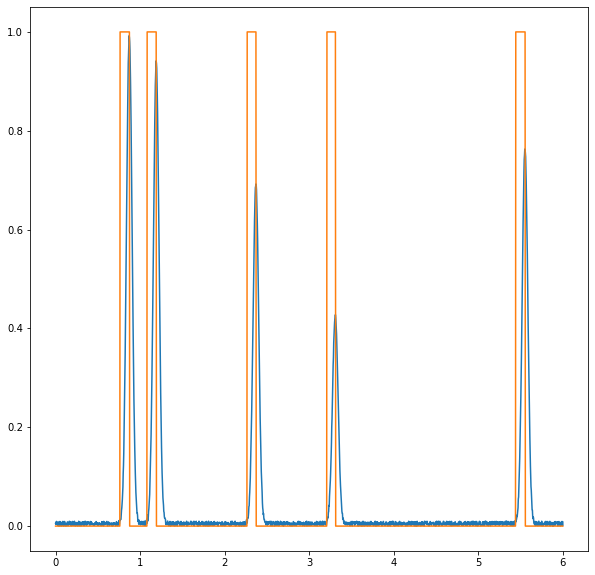

In [436]:
plt.figure(figsize=(10,10))
plt.plot(time,ts)
plt.plot(time,foo)

Try some "out-of-the-box" peak finding methods as well.

In [493]:
i_peaks,_ = scipy.signal.find_peaks(
    ts,
    height=noise_threshold,
    distance=4,
    prominence=
)

In [494]:
plt.figure(figsize=(10,10))
plt.plot(time,ts)
plt.plot(time[i_peaks], ts[i_peaks],
         ls='', marker='o', markersize=10)